# GLM Module

One of the major changes in the 0.7.0 release of Nilearn was the inclusion of all the functionalities of [Nistats](https://nistats.github.io) within the module `glm`. 

<div class="alert alert-block alert-danger">
<b>Danger:</b> This module is experimental, hence subject to change in any future release.
</div>

In case you were previously using Nistats, we strongly recommand that you switch to Nilearn as Nistats isn't maintained anymore. Note that a guide to replacing Nistats imports to work in Nilearn is available on the documentation website [here](https://nilearn.github.io/nistats_migration.html).

## Objectives of this notebook

The GLM module provides a lot of functionalities that we cannot cover in reasonable time here. Our goal here is simply to advertise its existence, show how one can run standard analysis with this module, and provide some pointers to relevant ressources.

The outline is the following:

- <a href="#functionalities">Available functionalities</a>
- <a href="#first">First Level Models</a>
- <a href="#second">Second Level Models</a>

<span id="functionalities"></span>

## Available functionalities

The GLM module uses [Generalized Linear Model](https://en.wikipedia.org/wiki/Generalized_linear_model) to analyse functional MRI data. Nilearn offers functions to set up first- and second-level models, perform t-tests, multiple-comparisons correction and thresholding, and allows for the generation of html reports that detail the analyses performed and present thresholded results.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you are not familiar with GLMs, we recommand that you browse through the Nilearn glm tutorial <a href="http://nilearn.github.io/glm/glm_intro.html#a-primer-on-bold-fmri-data-analysis">here</a></div>



First of all, make sure you have nilearn >= 0.7.0 installed:

In [1]:
import nilearn
print(nilearn.__version__)

0.7.2.dev


Note that you will get a warning when importing the GLM module since it is still considered experimental as its addition is very recent:

In [2]:
import nilearn.glm

/home/nicolas/GitRepos/nilearn-fork/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


<span id="first"></span>

## First Level Models

### Description

First level models are, in essence, linear regression models run at the level of a single session or single subject. The model is applied on a voxel-wise basis, either on the whole brain or within a region of interest. The timecourse of each voxel is regressed against a predicted BOLD response created by convolving the haemodynamic response function (HRF) with a set of predictors defined within the design matrix.

Most of the time, a first level analysis is composed of the following steps:

1. Load a sequence of fMRI volumes.
2. Build a design matrix which describes all the effects related to the data.
3. Compute a mask of the useful brain volume or ROI.
4. Apply a GLM to the dataset (effect/covariance, then contrast estimation).

### Example

This example is inspired from the documentation of Nilearn [here](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_fiac_analysis.html#sphx-glr-auto-examples-04-glm-first-level-plot-fiac-analysis-py). We will follow the sequence of steps detailed above:

**1. Load sequence of fMRI volumes**

In [3]:
from nilearn.datasets import fetch_fiac_first_level
from nilearn.image import mean_img

data = fetch_fiac_first_level()
fmri_img = [data['func1'], data['func2']]
mean_img_ = mean_img(fmri_img[0]) # This will be used for plotting...

Missing functional scan for session 1.
Data absent, downloading...


/home/nicolas/GitRepos/nilearn-fork/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
Extracting data from /home/nicolas/nilearn_data/fiac_nilearn.glm/nipy-data-0.2.tar.gz...

Error uncompressing file: Compressed file ended before the end-of-stream marker was reached
Archive corrupted, trying to download it again.


In [4]:
data.keys()

dict_keys(['func1', 'design_matrix1', 'func2', 'design_matrix2', 'mask'])

**2. Build design matrices**

In [5]:
import numpy as np
import pandas as pd

design_files = [data['design_matrix1'], 
                data['design_matrix2']]
design_matrices = [pd.DataFrame(np.load(df)['X']) for df in design_files]
design_matrices[0].head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.180236e-14,-7.781773e-14,2.827377e-14,7.678016e-14,5.187849e-15,6.488857,6.488637,6.487979,6.486882,6.485346,6.483372,6.480959,6.478107
1,-8.559950e-15,-7.055474e-14,-1.400719e-14,6.847960e-14,1.099824e-13,6.488857,6.487364,6.482886,6.475424,6.464983,6.451567,6.435182,6.415836
2,-2.879256e-14,-6.640446e-14,1.010334e-13,5.758512e-14,5.162890e+00,6.488857,6.483325,6.466740,6.439130,6.400542,6.351042,6.290713,6.219659


We can plot design matrices using the function `plot_design_matrix` from the `plotting` module:

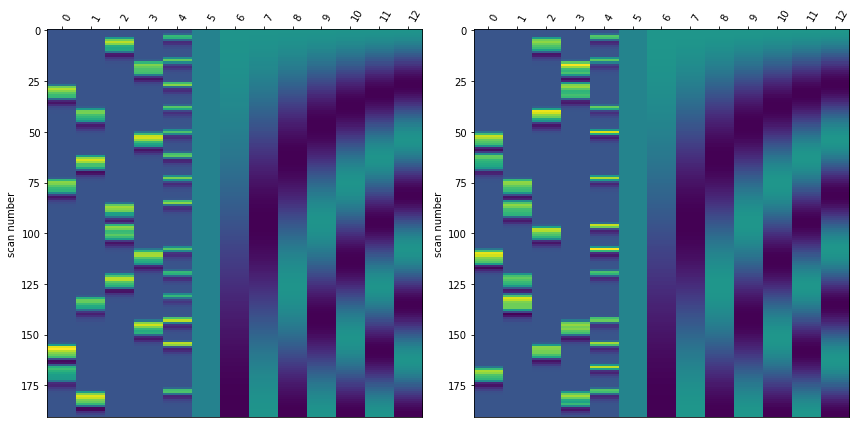

In [6]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121) 
plot_design_matrix(design_matrices[0], ax=ax)
ax2 = fig.add_subplot(122)
plot_design_matrix(design_matrices[1], ax=ax2)
plt.tight_layout()

In [7]:
from nilearn.glm.first_level import FirstLevelModel

# Instanciate the model using the mask
# provided in the dataset
fmri_glm = FirstLevelModel(mask_img=data['mask'], 
                           minimize_memory=True)

In [8]:
n_columns = design_matrices[0].shape[1]
contrast_val = np.hstack(([-1, -1, 1, 1], np.zeros(n_columns - 4)))
contrast_val

array([-1., -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Note that you can plot the contrast using the `plot_contrast_matrix` function:

<AxesSubplot:label='conditions'>

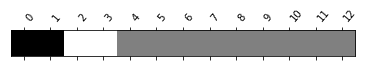

In [9]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(contrast_val, design_matrices[0])

Statistics for the first session

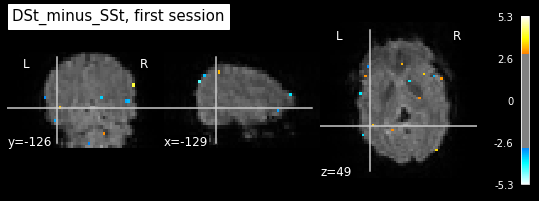

In [10]:
from nilearn.plotting import plot_stat_map

cut_coords = [-129, -126, 49]
contrast_id = 'DSt_minus_SSt'

fmri_glm = fmri_glm.fit(fmri_img[0],
                        design_matrices=design_matrices[0])

summary_statistics_session1 = fmri_glm.compute_contrast(
    contrast_val, output_type='all')

plot_stat_map(summary_statistics_session1['z_score'],
              bg_img=mean_img_,
              threshold=3.0,
              cut_coords=cut_coords,
              title='{0}, first session'.format(contrast_id))

Statistics for the second session

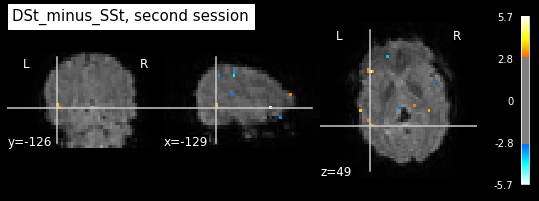

In [11]:
fmri_glm = fmri_glm.fit(fmri_img[1], 
                        design_matrices=design_matrices[1])

summary_statistics_session2 = fmri_glm.compute_contrast(
    contrast_val, output_type='all')

plot_stat_map(summary_statistics_session2['z_score'],
              bg_img=mean_img_,
              threshold=3.0,
              cut_coords=cut_coords,
              title='{0}, second session'.format(contrast_id))

Fixed effects statistics

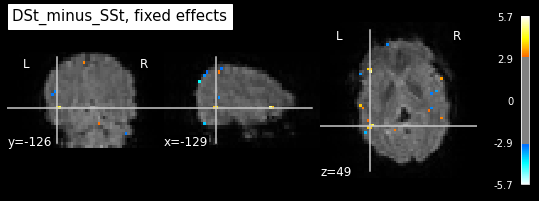

In [12]:
from nilearn.glm.contrasts import compute_fixed_effects

contrast_imgs = [summary_statistics_session1['effect_size'],
                 summary_statistics_session2['effect_size']]

variance_imgs = [summary_statistics_session1['effect_variance'],
                 summary_statistics_session2['effect_variance']]

fixed_fx_contrast, fixed_fx_variance, fixed_fx_stat = compute_fixed_effects(
    contrast_imgs, variance_imgs, data['mask'])

plot_stat_map(fixed_fx_stat,
              bg_img=mean_img_,
              threshold=3.0,
              cut_coords=cut_coords,
              title='{0}, fixed effects'.format(contrast_id))

<span id="second"></span>

## Second Level Models

Second level models in Nilearn are used to perform group-level analyses on fMRI data. Once individual subjects have been processed in a common space (e.g. MNI, Talairach, or subject average), the data can be grouped and statistical tests performed to make broader inferences on fMRI activity. Some common second level models are one-sample (unpaired or paired) and two-sample t-tests.

For simplicity, we download here a list of left vs right button press contrasts from a localizer dataset:

In [13]:
from nilearn.datasets import fetch_localizer_contrasts

n_subjects = 16

sample_vertical = fetch_localizer_contrasts(["vertical checkerboard"], 
                                            n_subjects, 
                                            get_tmaps=True)
sample_horizontal = fetch_localizer_contrasts(["horizontal checkerboard"], 
                                              n_subjects, 
                                              get_tmaps=True)
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

/home/nicolas/anaconda3/envs/nilearn/lib/python3.8/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Next, we model the effect of conditions (sample 1 vs sample 2).

In [14]:
condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))
condition_effect

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

Subsequently, we can model the subject effect: each subject is observed in sample 1 and sample 2.

In [15]:
subjects = ['S%02d' % i for i in range(1, n_subjects + 1)]
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))

We then assemble those in a design matrix:

In [16]:
design_matrix = pd.DataFrame(
                    np.hstack((condition_effect[:, np.newaxis], 
                               subject_effect)),
                    columns=['vertical vs horizontal'] + subjects)
design_matrix.head(3)

,vertical vs horizontal,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S15,S16
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As for first level design matrices, we can plot this matrix using the function `plot_design_matrix`:

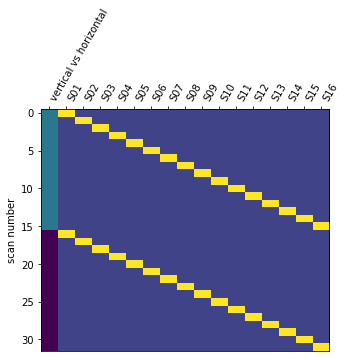

In [17]:
plot_design_matrix(design_matrix)
plt.tight_layout()

Initialize the second level model and fit:

In [18]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel().fit(second_level_input, 
                                            design_matrix=design_matrix)

Estimating the contrast is very simple. We can just provide the column name of the design matrix:

In [19]:
z_map = second_level_model.compute_contrast('vertical vs horizontal',
                                            output_type='z_score')

We threshold the second level contrast and plot it:

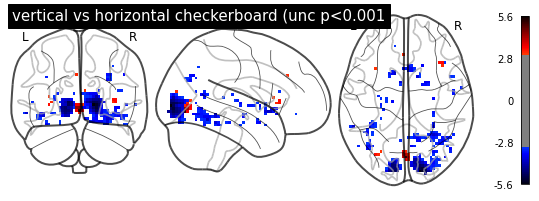

In [20]:
from nilearn.plotting import plot_glass_brain

threshold = 3.1  # correponds to  p < .001, uncorrected

plot_glass_brain(z_map, 
                 threshold=threshold, 
                 colorbar=True, 
                 plot_abs=False,
                 title='vertical vs horizontal checkerboard (unc p<0.001')

Unsurprisingly, we see activity in the primary visual cortex, both positive and negative.

### References

- [Simple example of two-session fMRI model fitting](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_fiac_analysis.html#sphx-glr-auto-examples-04-glm-first-level-plot-fiac-analysis-py)
- [Single-subject data (two sessions) in native space](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_spm_multimodal_faces.html#sphx-glr-auto-examples-04-glm-first-level-plot-spm-multimodal-faces-py)
- Seed based GLM: [Default Mode Network extraction of AHDH dataset](http://nilearn.github.io/auto_examples/04_glm_first_level/plot_adhd_dmn.html#sphx-glr-auto-examples-04-glm-first-level-plot-adhd-dmn-py)